In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statistics import median
import numpy as np
import functools as ft
from scipy.stats import wilcoxon
from VD_A import VD_A

In [3]:
def get_significant_classes_stats(
        output_csv,
        search_budget,
        compared_function,
        columns_to_group, 
        score_metric):
    """
    Get Wilcoxon and Vargha-Delaney statistics for all classes and return both significant and all classes along with their stats.
    """

    res = pd.read_csv(output_csv)
    configuration_ids = [
        'weak_' + str(search_budget),
        'branch_' + str(search_budget),
        'default_' + str(search_budget)]
    all_columns = columns_to_group + [score_metric]

    # Configuration column name is the second in the columns_to_group list
    config_column = columns_to_group[1]

    # Sort by configuration
    res = res.loc[:,all_columns]
    result = res[res.apply(lambda row : row[config_column] in configuration_ids, axis=1)]

    # "weak" groups
    weak_result = result.loc[result[config_column] == 'weak_' + str(search_budget)]
    weak_groups = weak_result.groupby(columns_to_group)[score_metric]

    # "compared" groups
    compared_func_result = result.loc[result[config_column] == str(compared_function) + '_' + str(search_budget)]
    compared_func_groups = compared_func_result.groupby(columns_to_group)[score_metric]

    # Create a dictionary with the 10 runs per class and the resulting branch coverage for the weak + branch fitness function
    weak_classes = dict()
    for name, group in weak_groups:
        weak_classes[name] = group.astype(float).to_numpy()

    # Create a dictionary with the 10 runs per class and the resulting branch coverage for the compared fitness function
    compared_func_classes = dict()
    for name, group in compared_func_groups:
        compared_func_classes[name] = group.astype(float).to_numpy()

    # If there are less than 10 runs for a class, pad the branch coverage with 0 
    def pad(val1, val2):
        if val1.shape[0] == val2.shape[0]:
            return val1, val2
        if val1.shape[0] < val2.shape[0]:
            return np.pad(val1, [(0, val2.shape[0]-val1.shape[0])]), val2
        else:
            return val1, np.pad(val2, [(0, val1.shape[0]-val2.shape[0])])

    # Calculate statistical significance per class
    # Apply the Wilcoxon test for (weak_classes, compared_classes) per batch of 10 runs
    # Apply A. Vargha and H. D. Delaney. per batch
    # Filter out non-significant classes and classes with less than 'large' effect size
    class_stats = dict()

    for ((key1, val1), (key2, val2)) in zip(weak_classes.items(), compared_func_classes.items()):

        val1, val2 = pad(val1, val2)

        # If both weak and compared score metrics are equal, then flag with (-2,-2)
        # Otherwise perform Wilcoxon and Vargha-Delaney
        stats_p = (-2,-2) if (np.sum(np.subtract(val1, val2)) == 0) else wilcoxon(val1, val2)
        vd = VD_A(val1.tolist(), val2.tolist())
        class_stats[key1[0]] = (stats_p, vd)
        # print(str(key1) + str(val1) + ", "+ str(key2) + str(val2) + " HAS P VALUE OF: " + str(p))

    significant_class_stats = dict()

    # Filter classes with 'p' < 0.05 and a large effect size 
    for (key, ((stats, p), vd)) in class_stats.items():
        # if (p > -2 and p < 0.05 and vd[1] == 'large'):
        if (p > -2 and p < 0.05 and vd[1] == 'large' and (vd[0] == 0 or vd[0] == 1)):
            significant_class_stats[key] = ((stats, p), vd) 
    
    # Return statistically significant class stats & all classes stats
    return significant_class_stats, class_stats

In [4]:
# Diverging Texts plot

def plot_diverging_text(search_budget, compared_class, classes_with_stats, score_metric, sample_range=None):

    df1 = pd.DataFrame.from_dict(classes_with_stats, orient='index')
    df1.rename(columns = {0: 'wilcoxon', 1:'vd'}, inplace = True)

    vd_df = df1.drop('wilcoxon', axis=1)
    df2 = (vd_df.apply(lambda x: x[0], axis=1, result_type='expand')).drop([1], axis=1)
    df2.rename(columns = {0: 'vd_estimate'}, inplace = True)
    # df = df2.iloc[: 100]
    df = df2
    df.sort_values('vd_estimate', inplace=True)
    
    if sample_range:
        df = df.iloc[sample_range[0]:sample_range[1]]

    # Draw plot
    plt.figure(figsize=(30,30), dpi= 80)
    plt.hlines(y=df.index, xmin=0.5, xmax=df.vd_estimate)
    for x, y, tex in zip(df.vd_estimate, df.index, df.vd_estimate):
        t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x >= 0.5 else 'left', 
                     verticalalignment='bottom', fontdict={'color':'red' if x < 0.5 else 'green', 'size':18})

    # Decorations    
    plt.yticks(df.index, fontsize=12)
    plt.title('Effect size per class (' + str(score_metric) + ') - bcwm vs ' + compared_class + ' - search budget ' + str(search_budget), fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-0.25, 1.25)
    plt.show()


/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


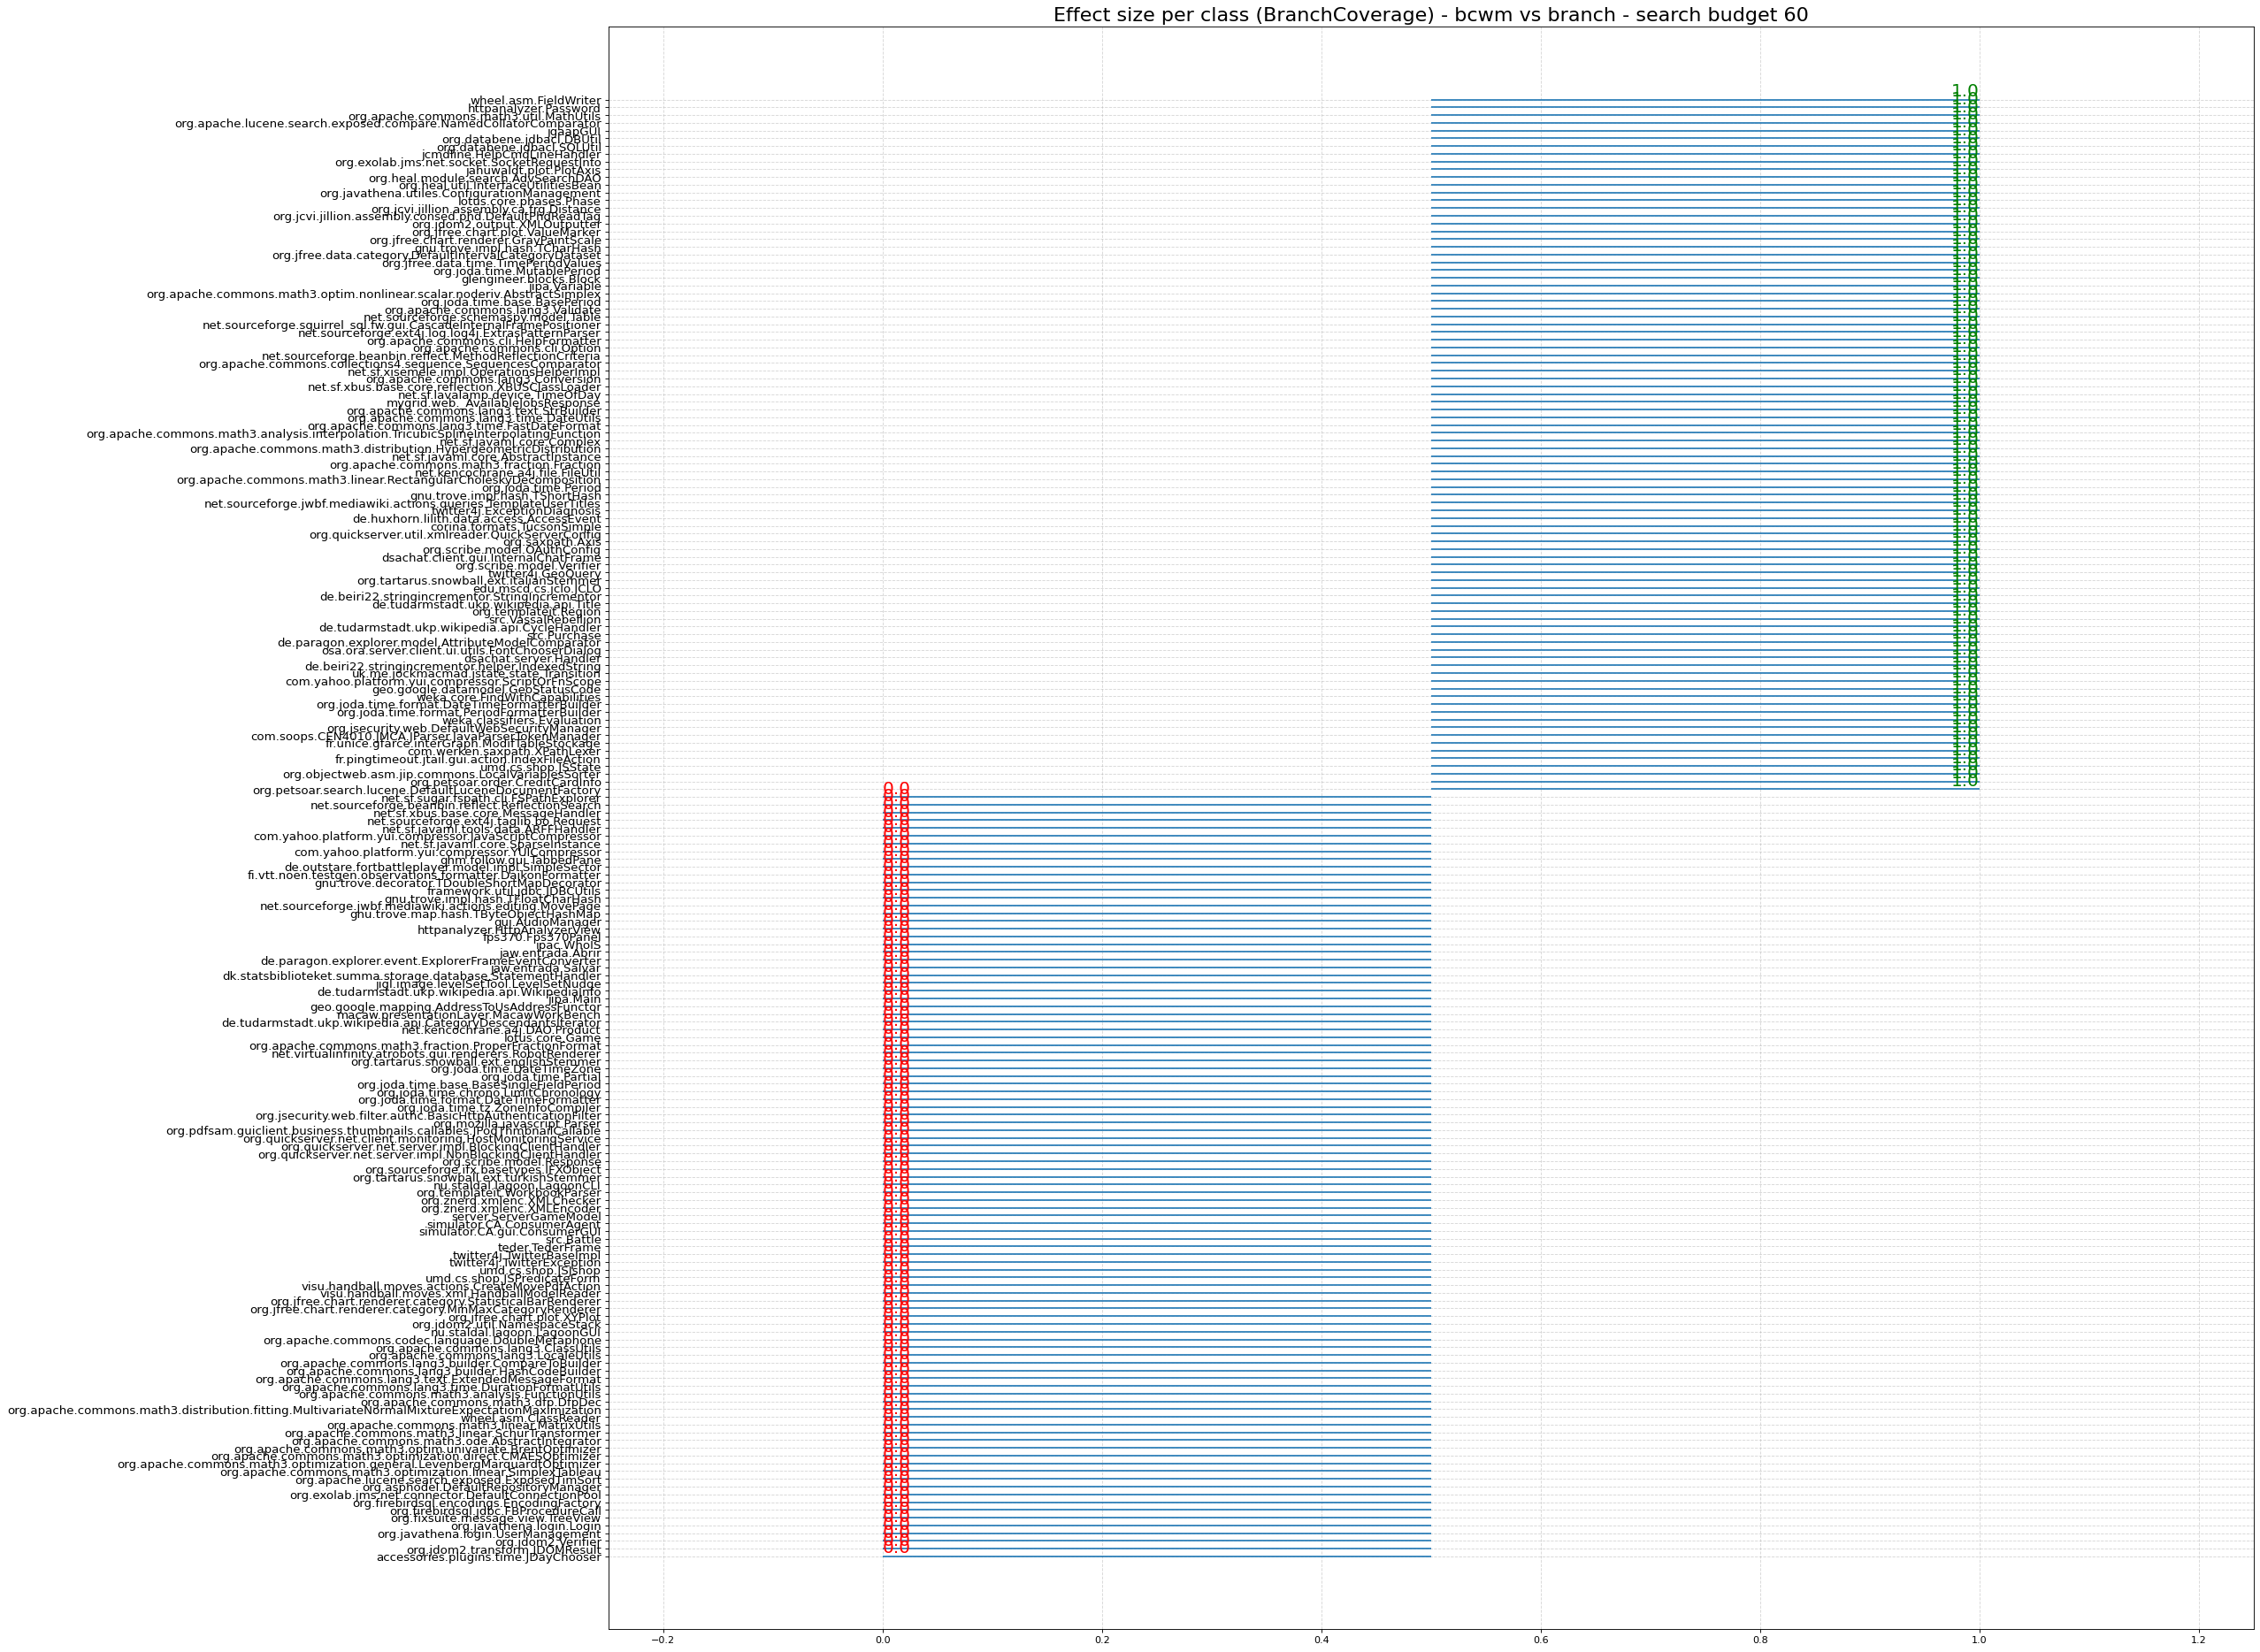

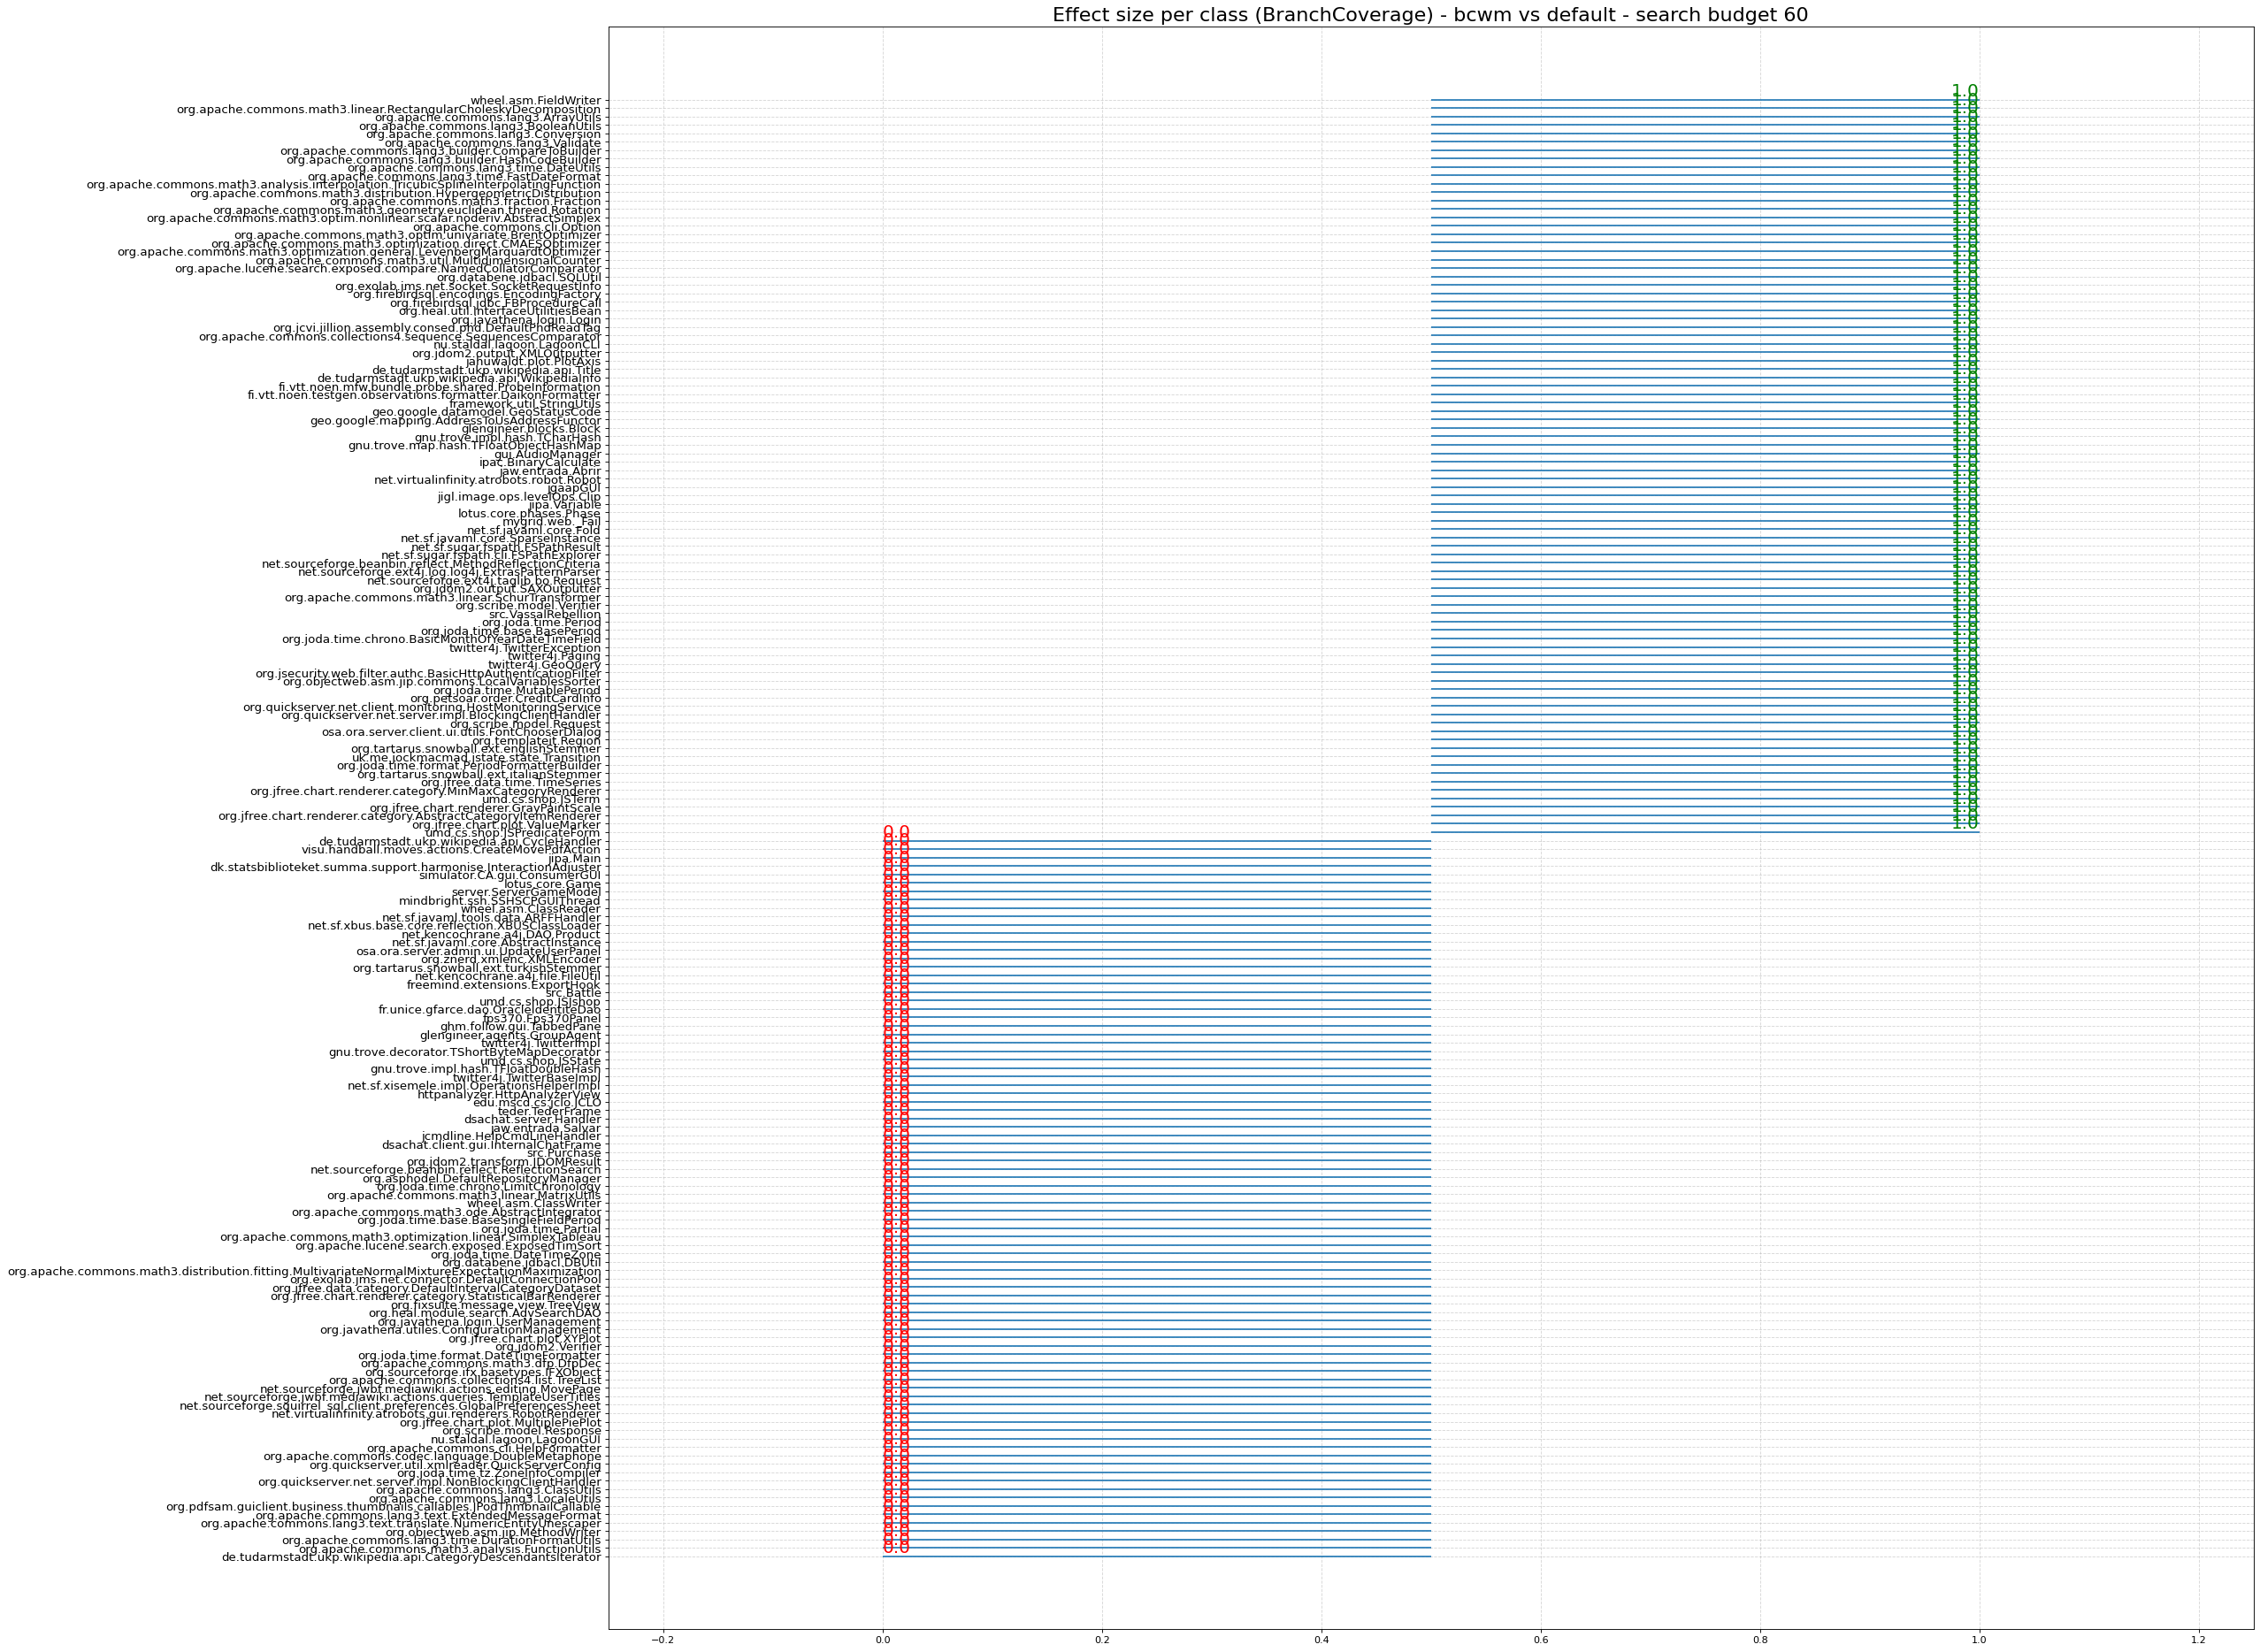

/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


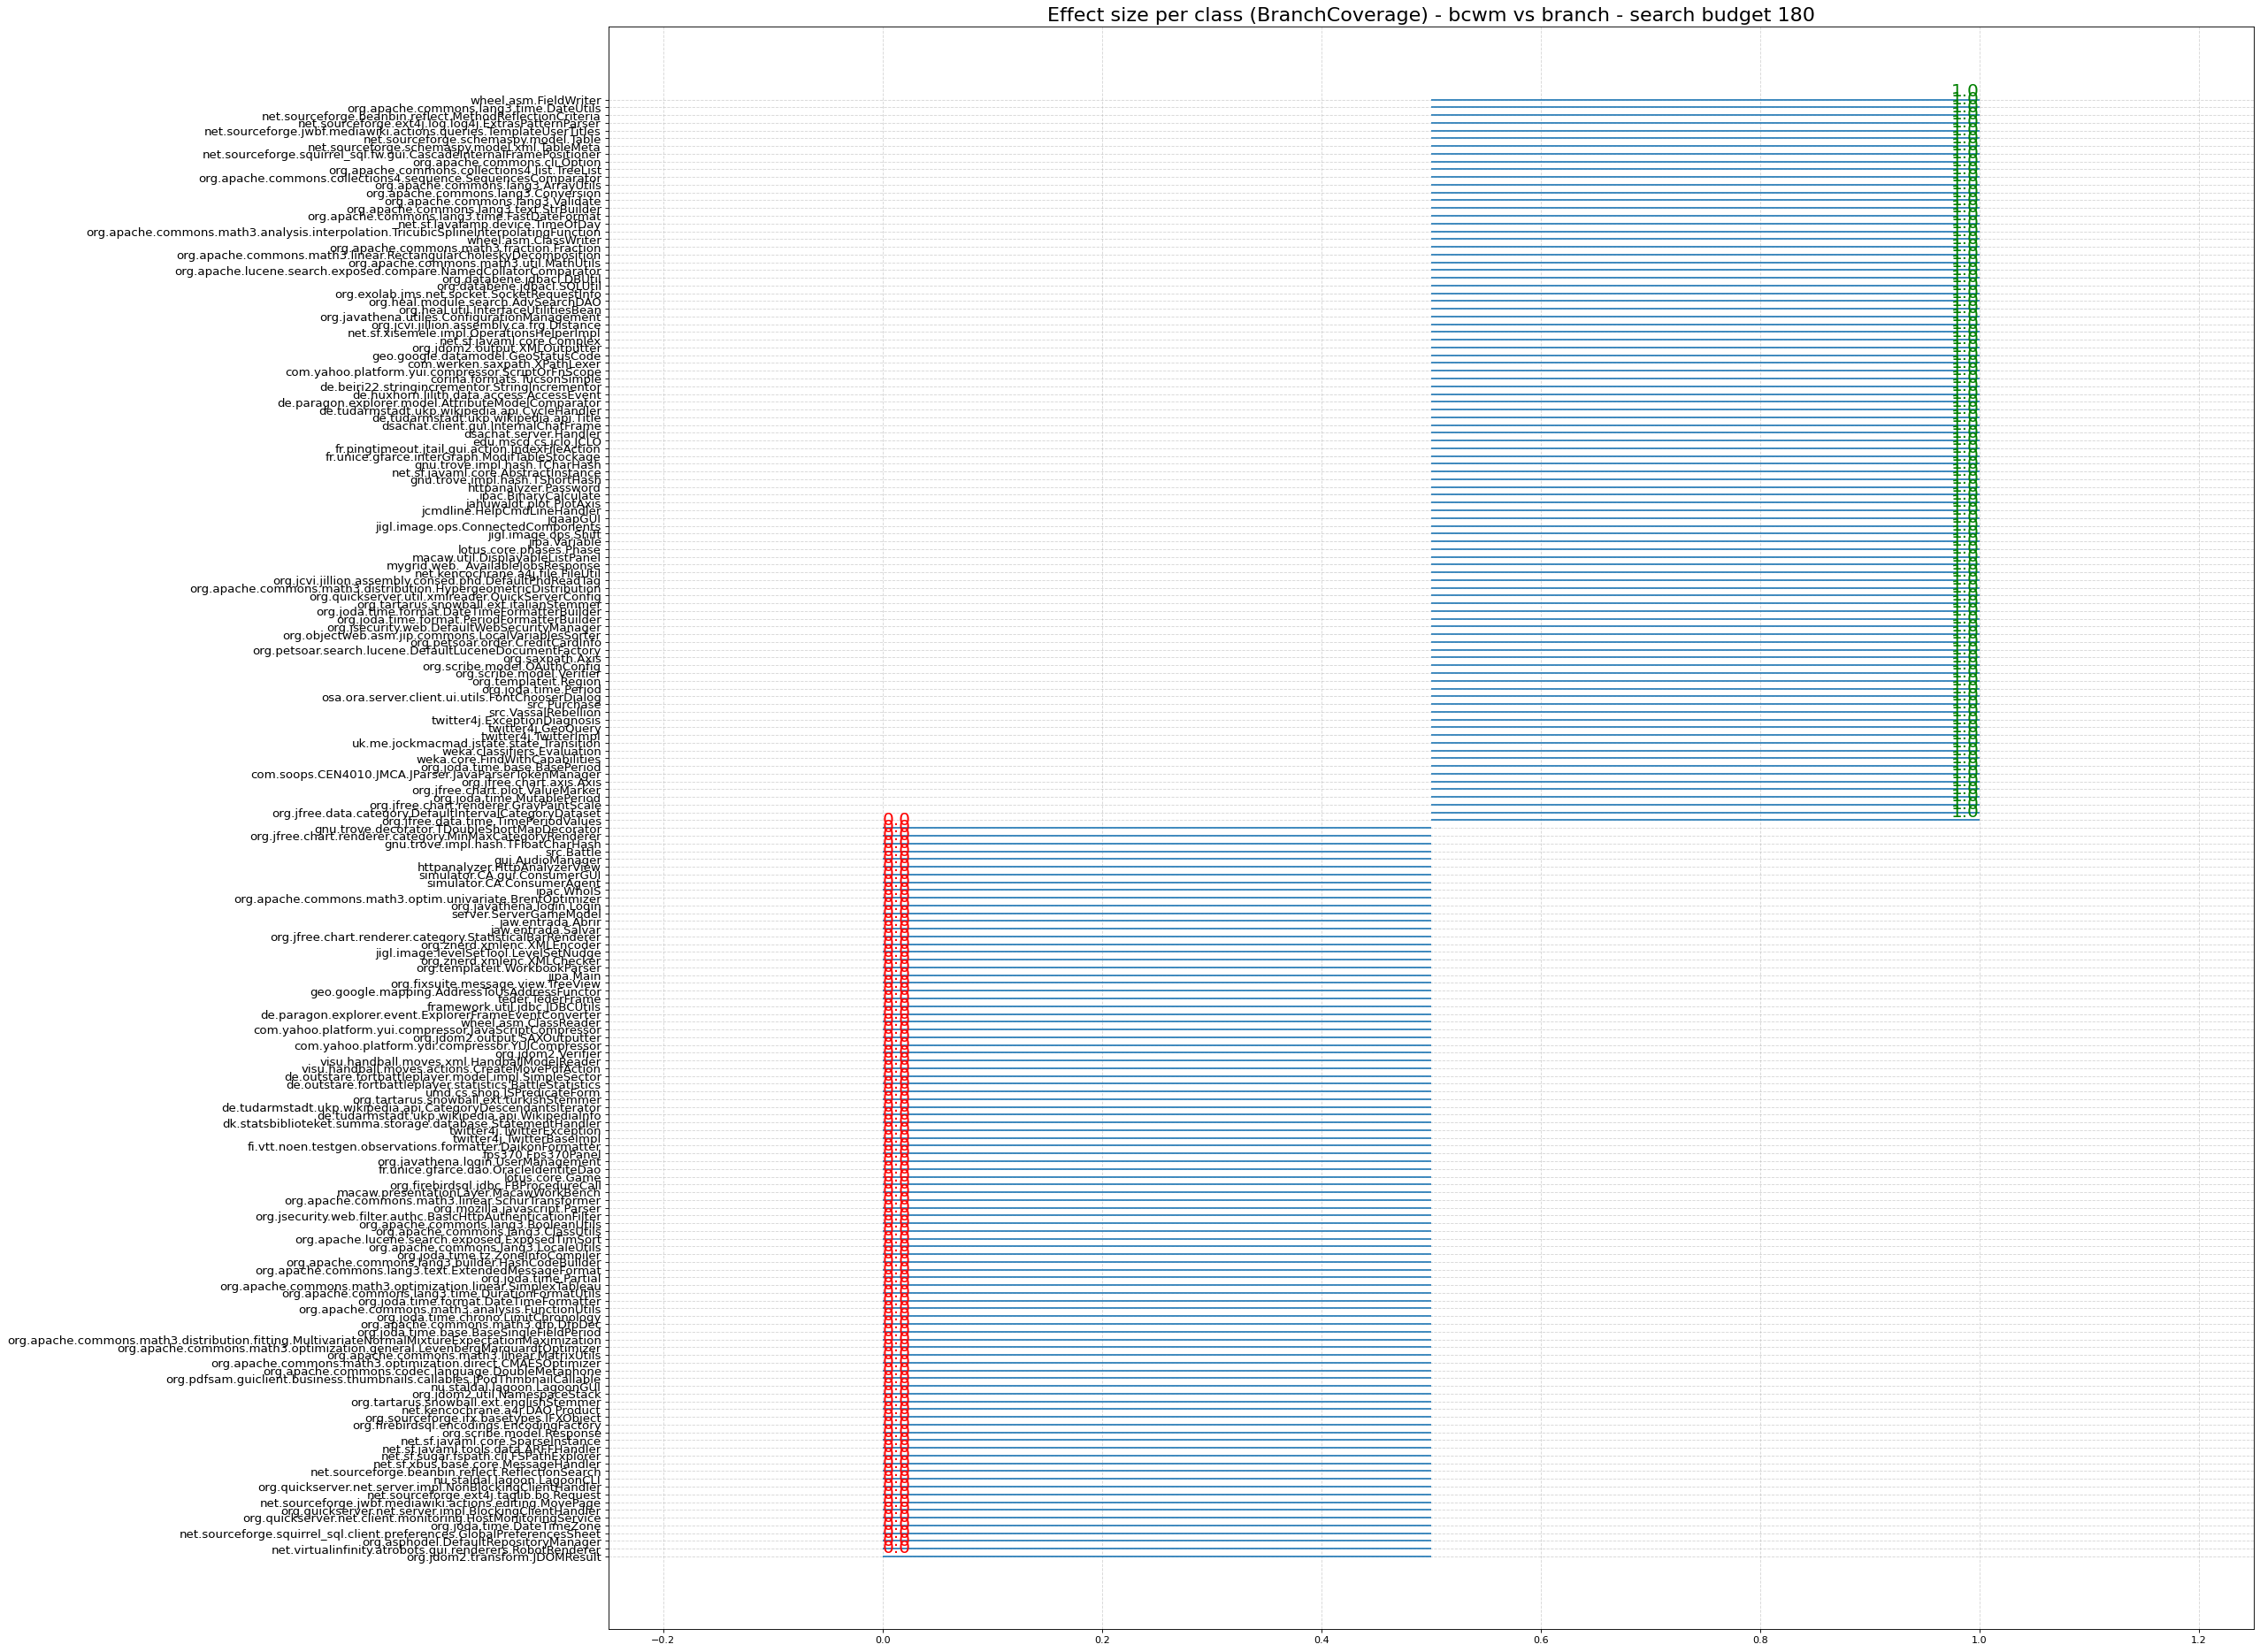

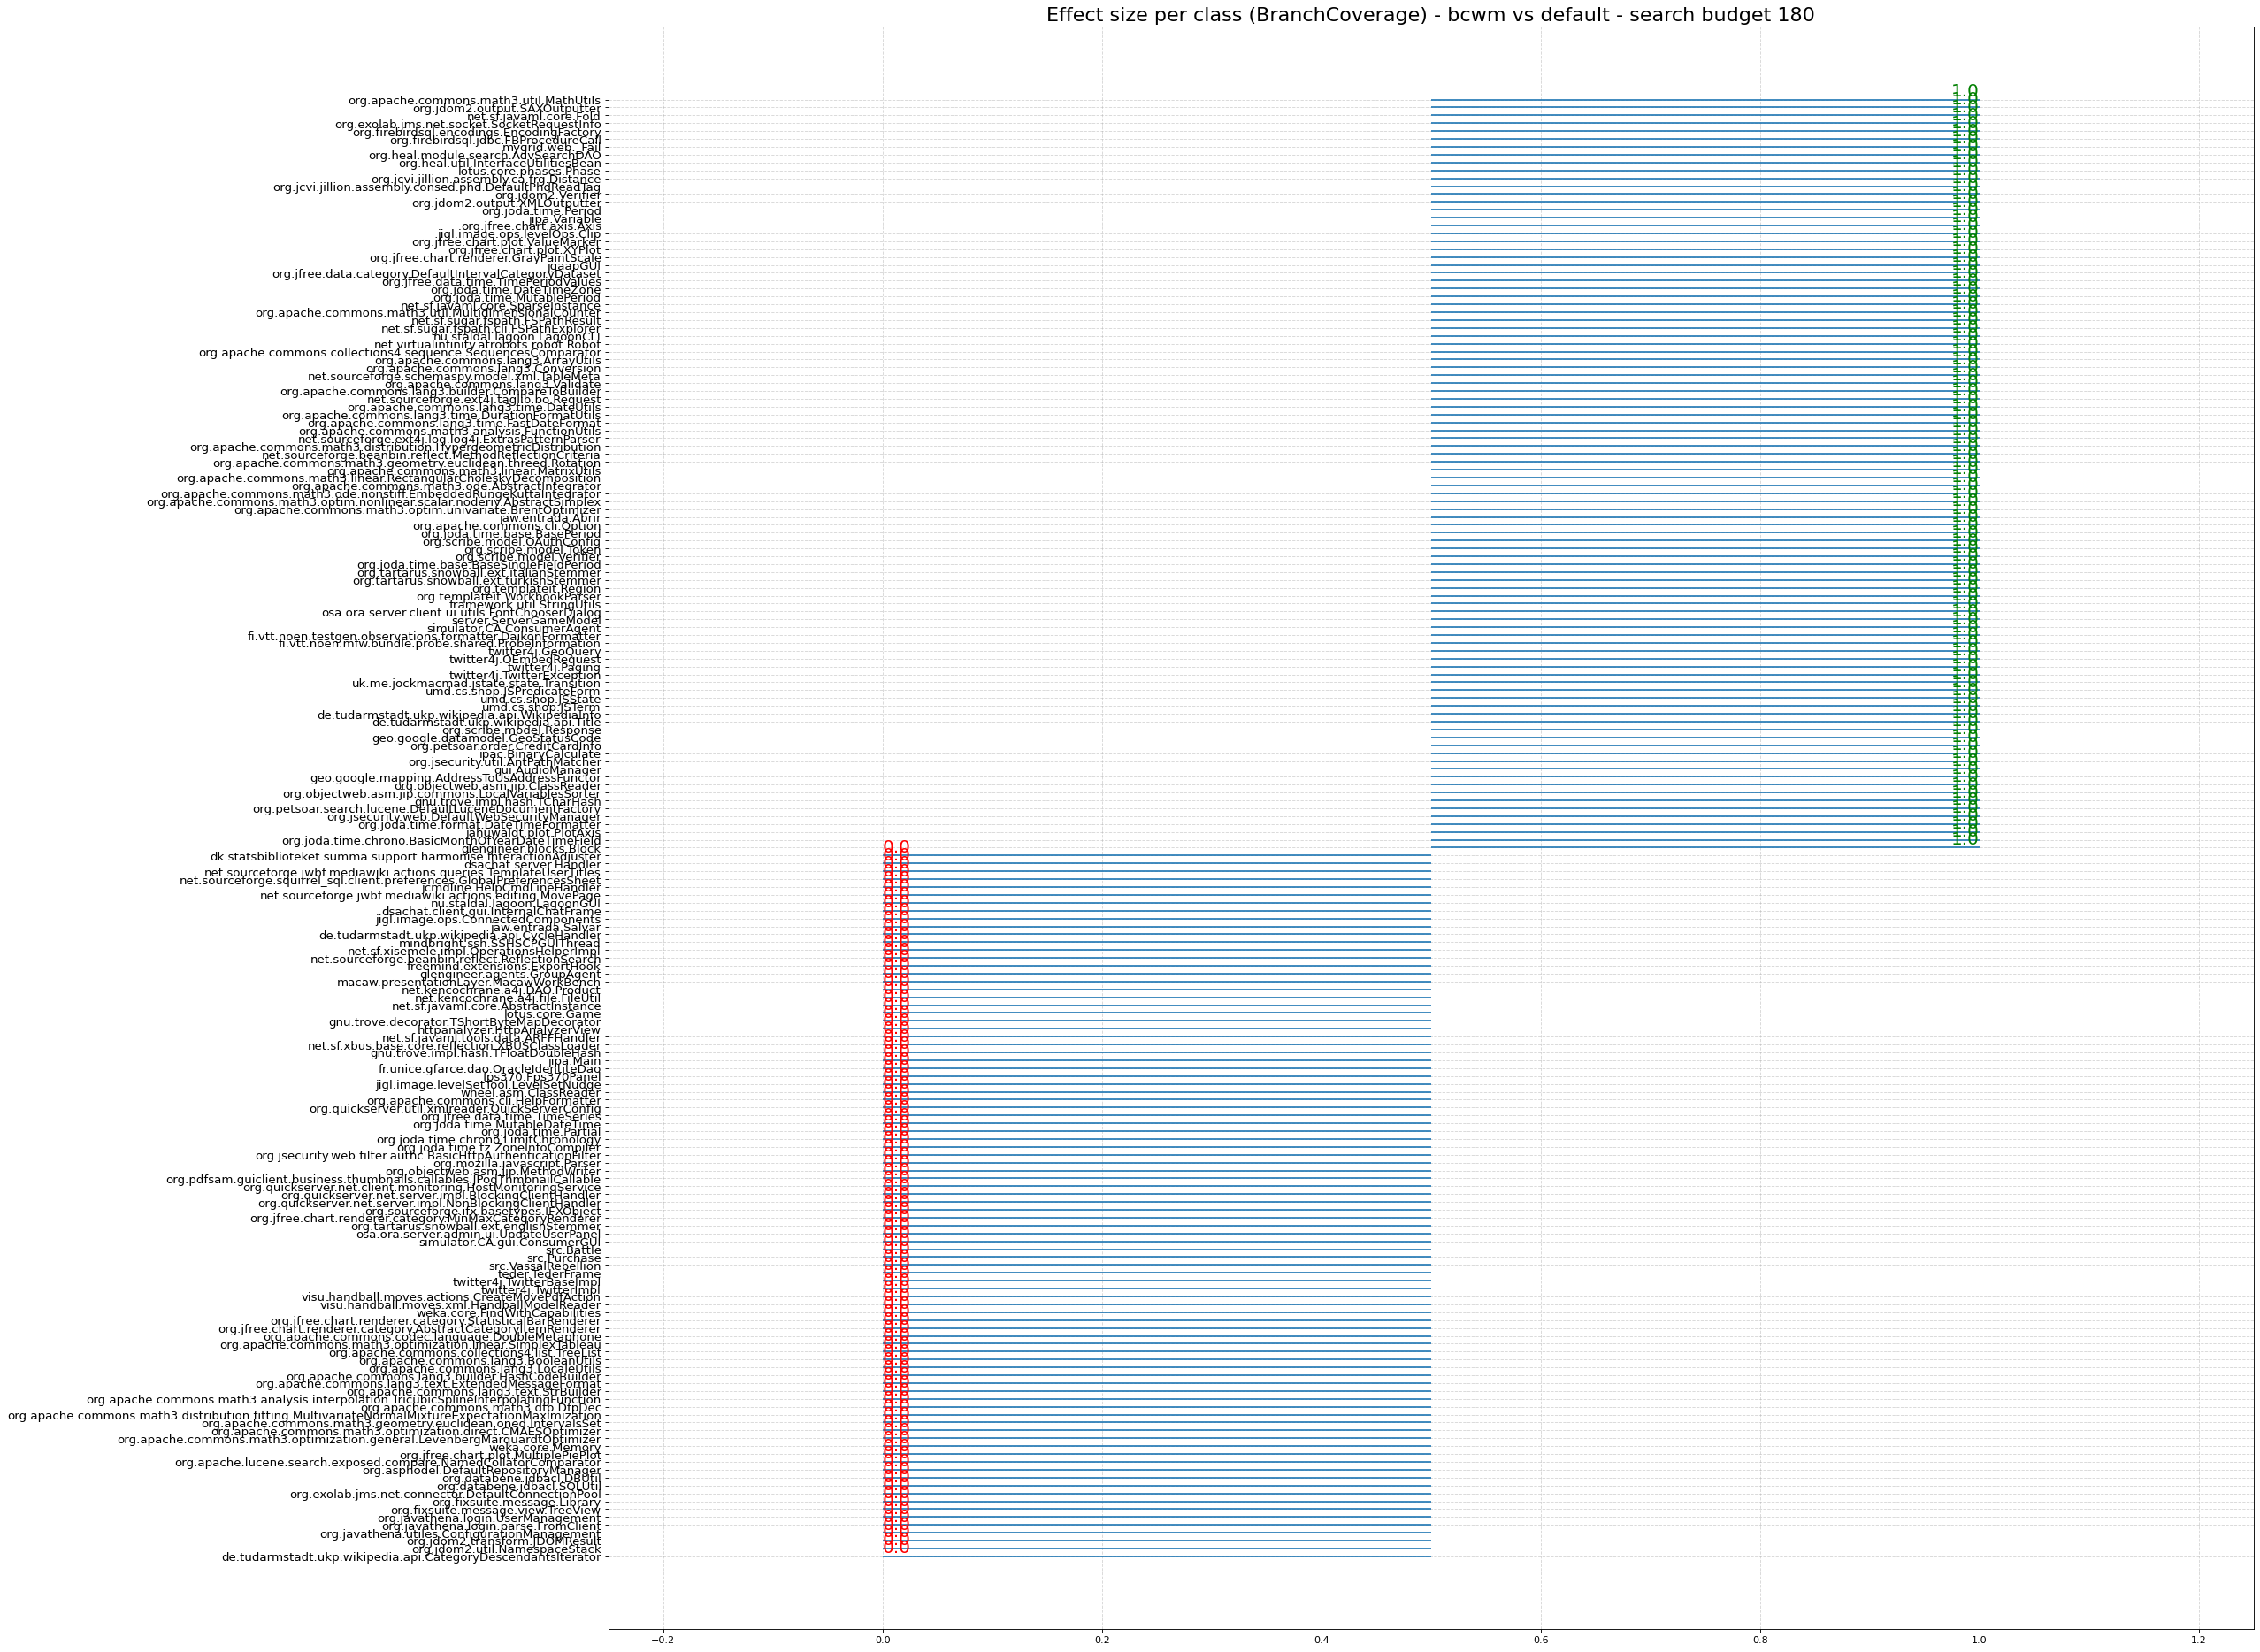

/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


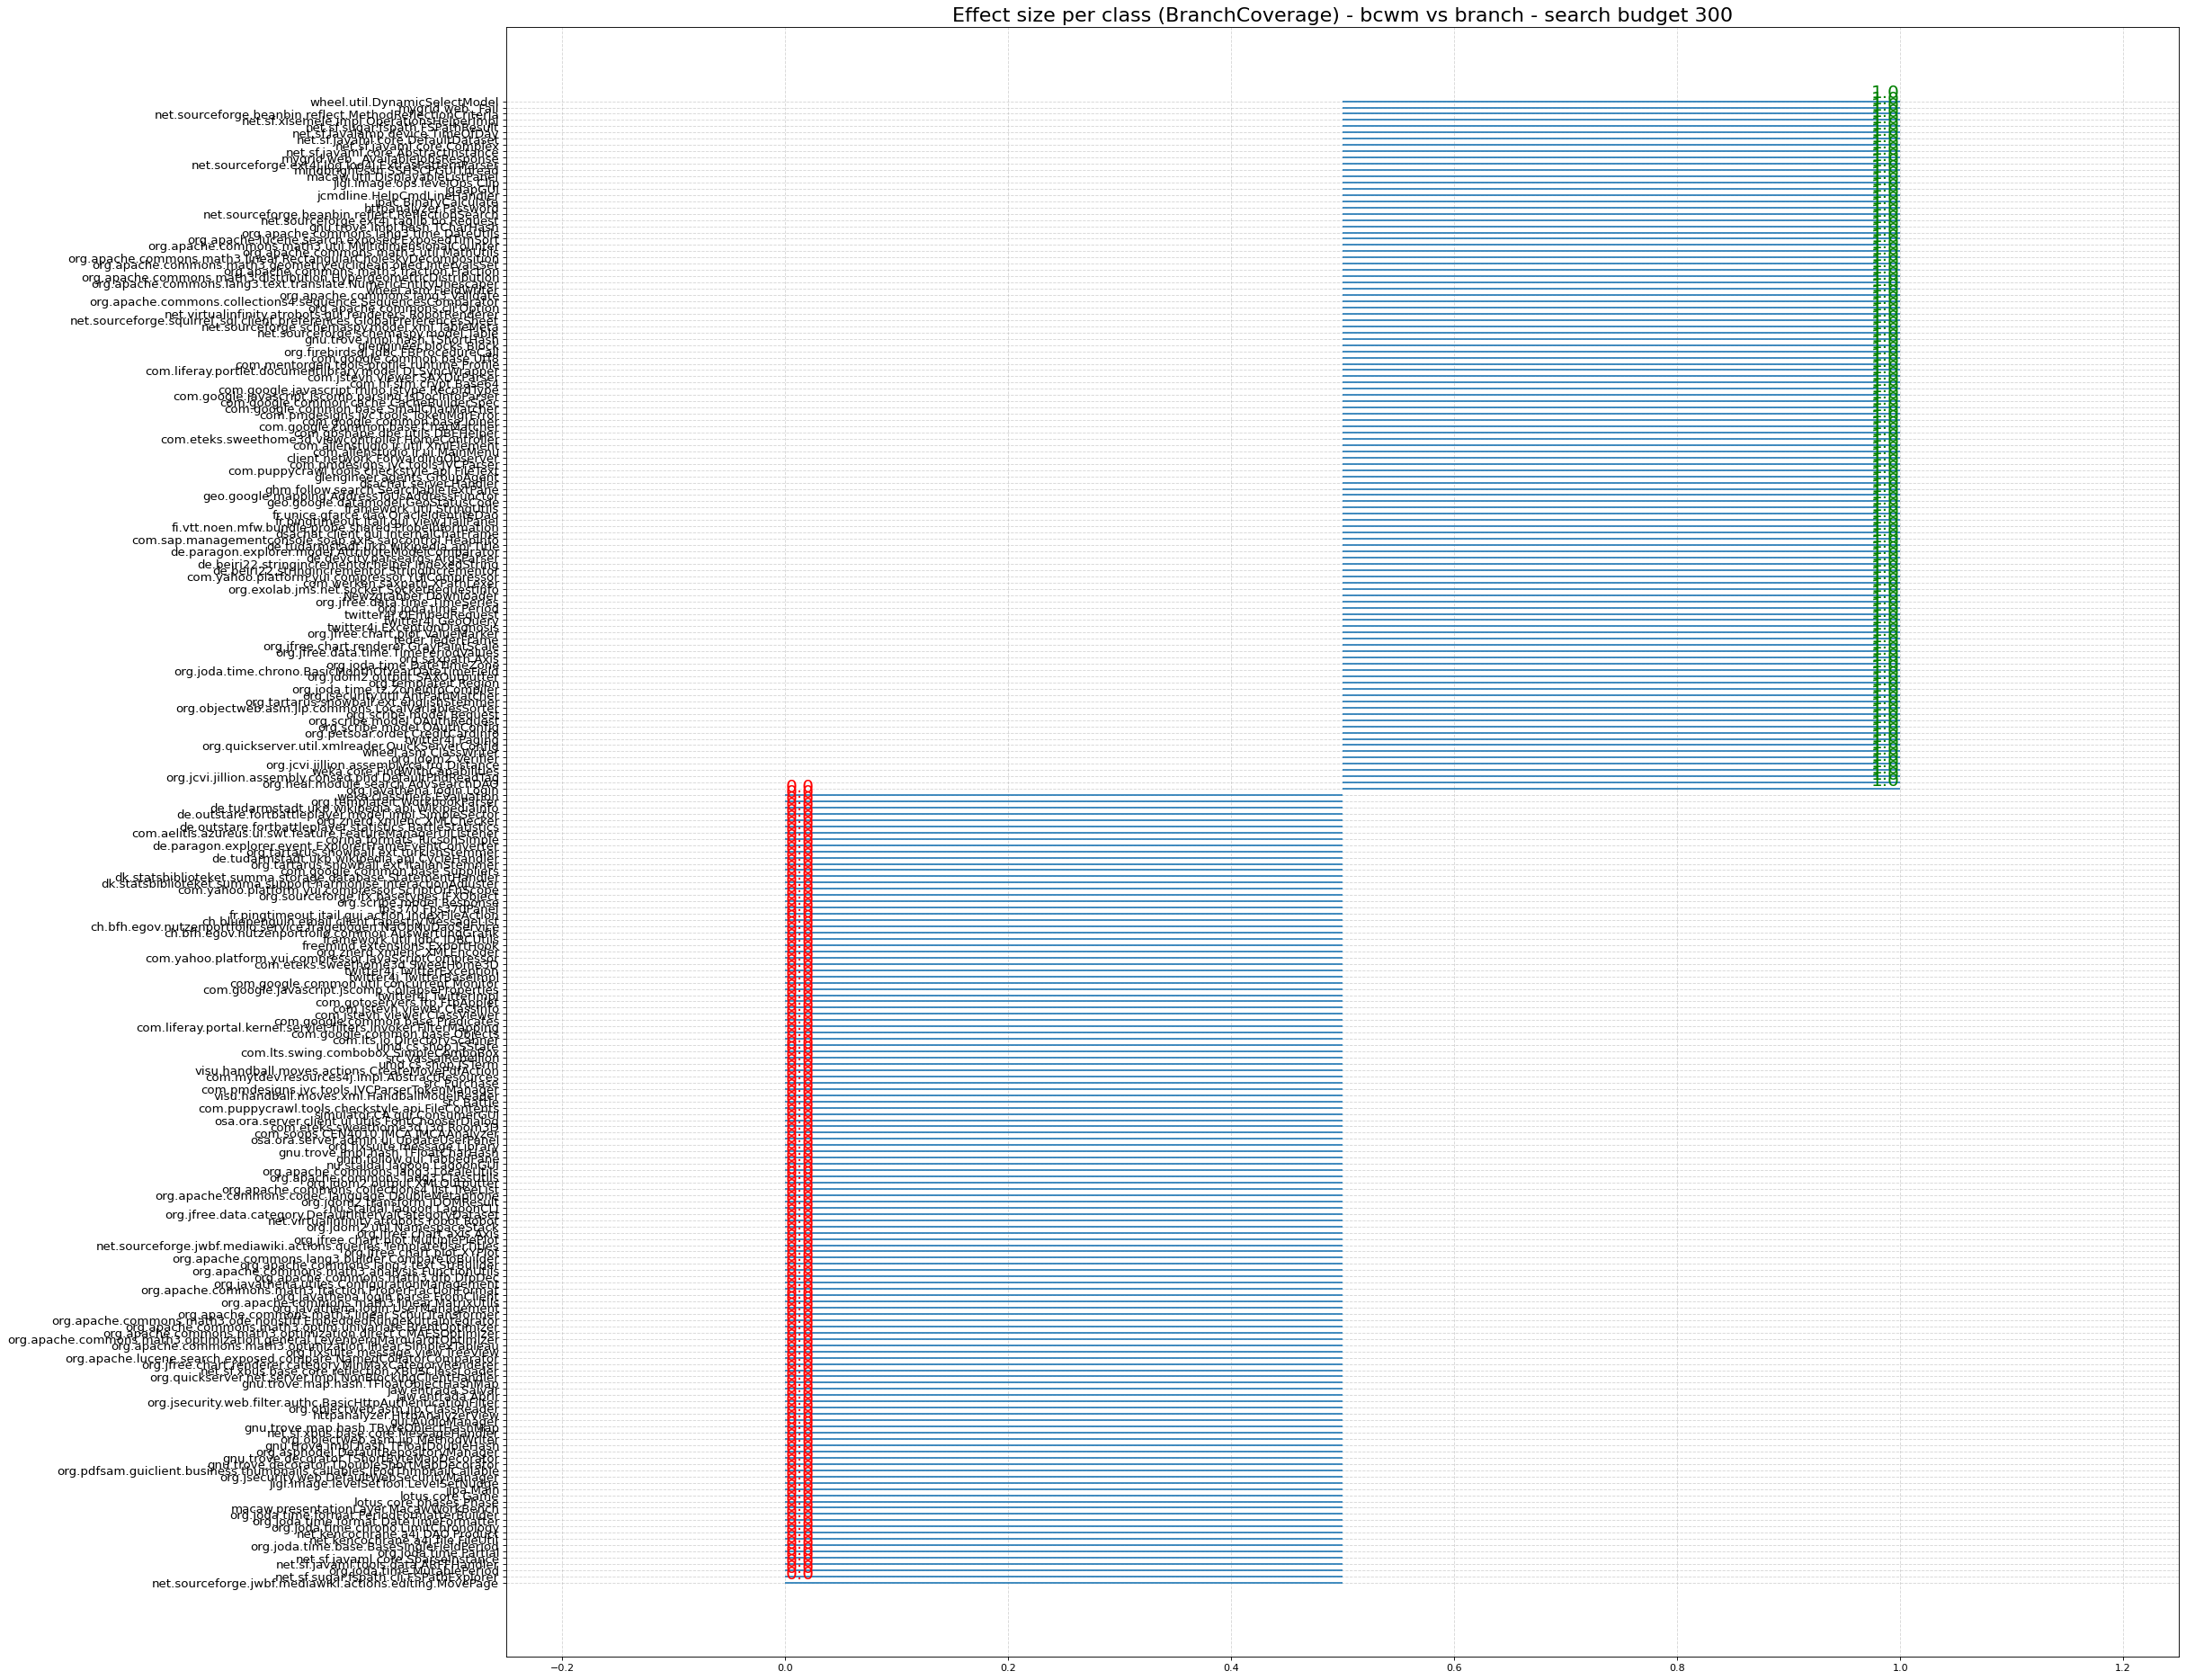

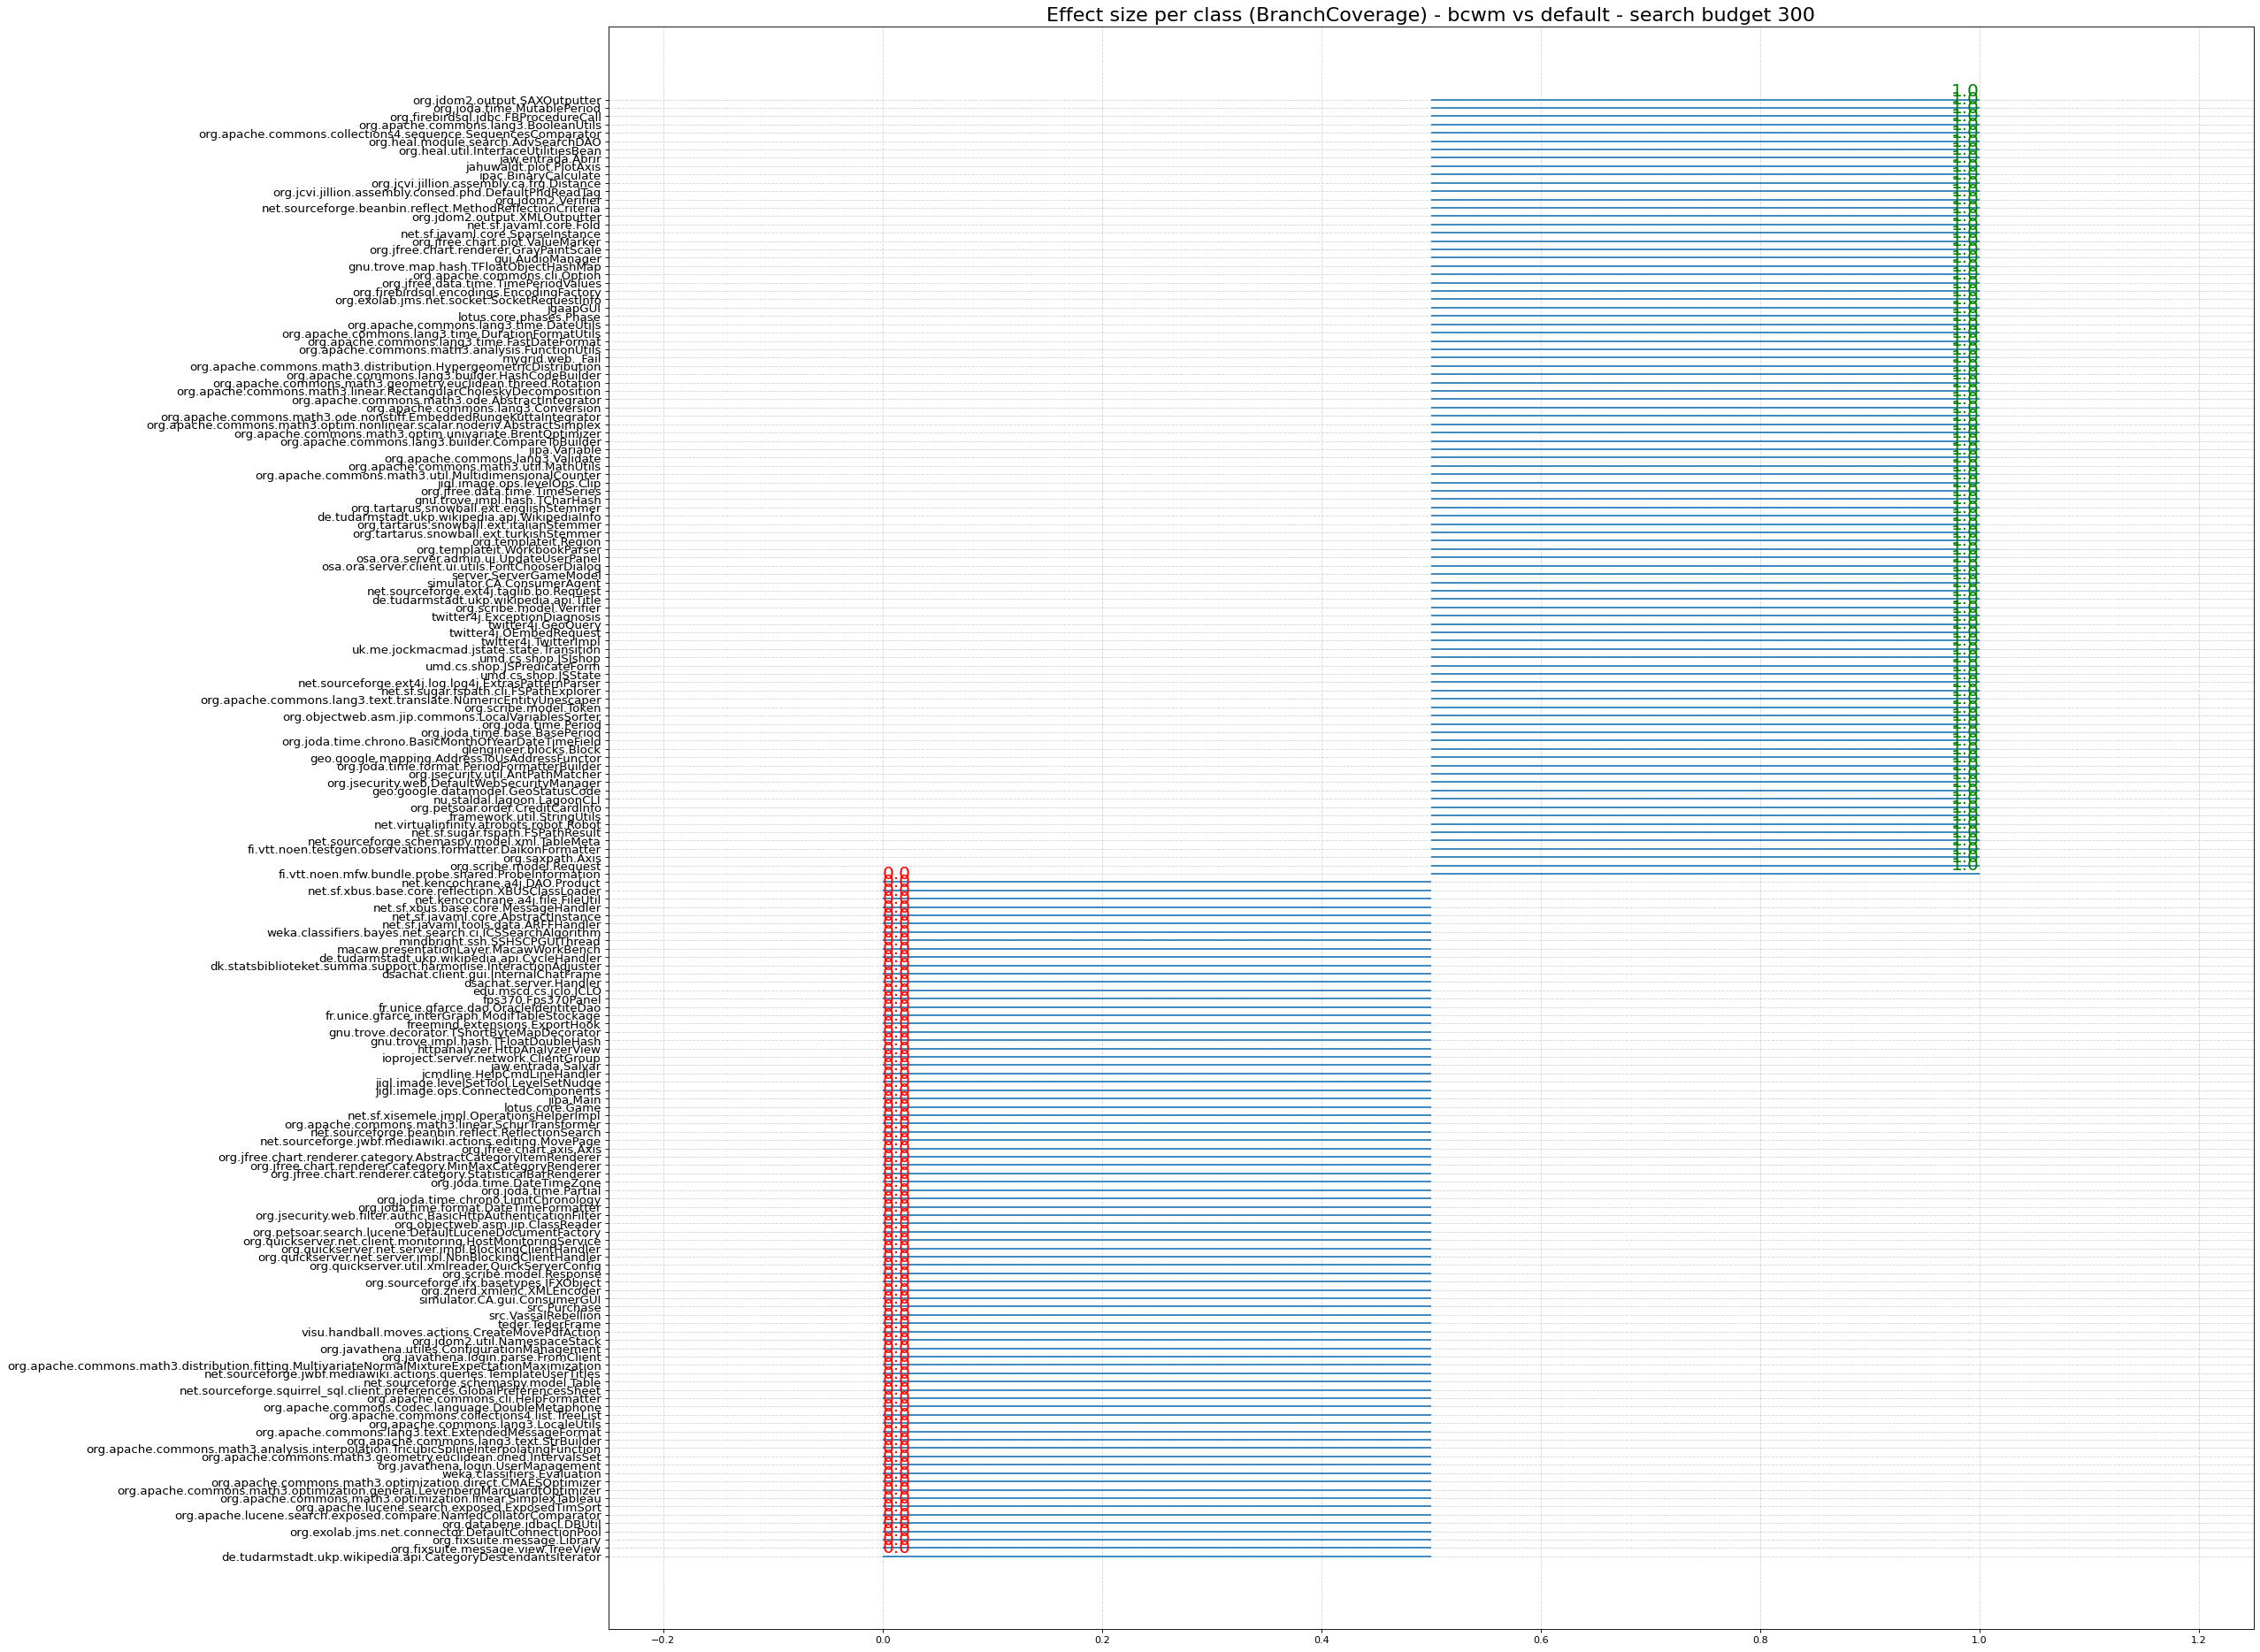

/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/daniela/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


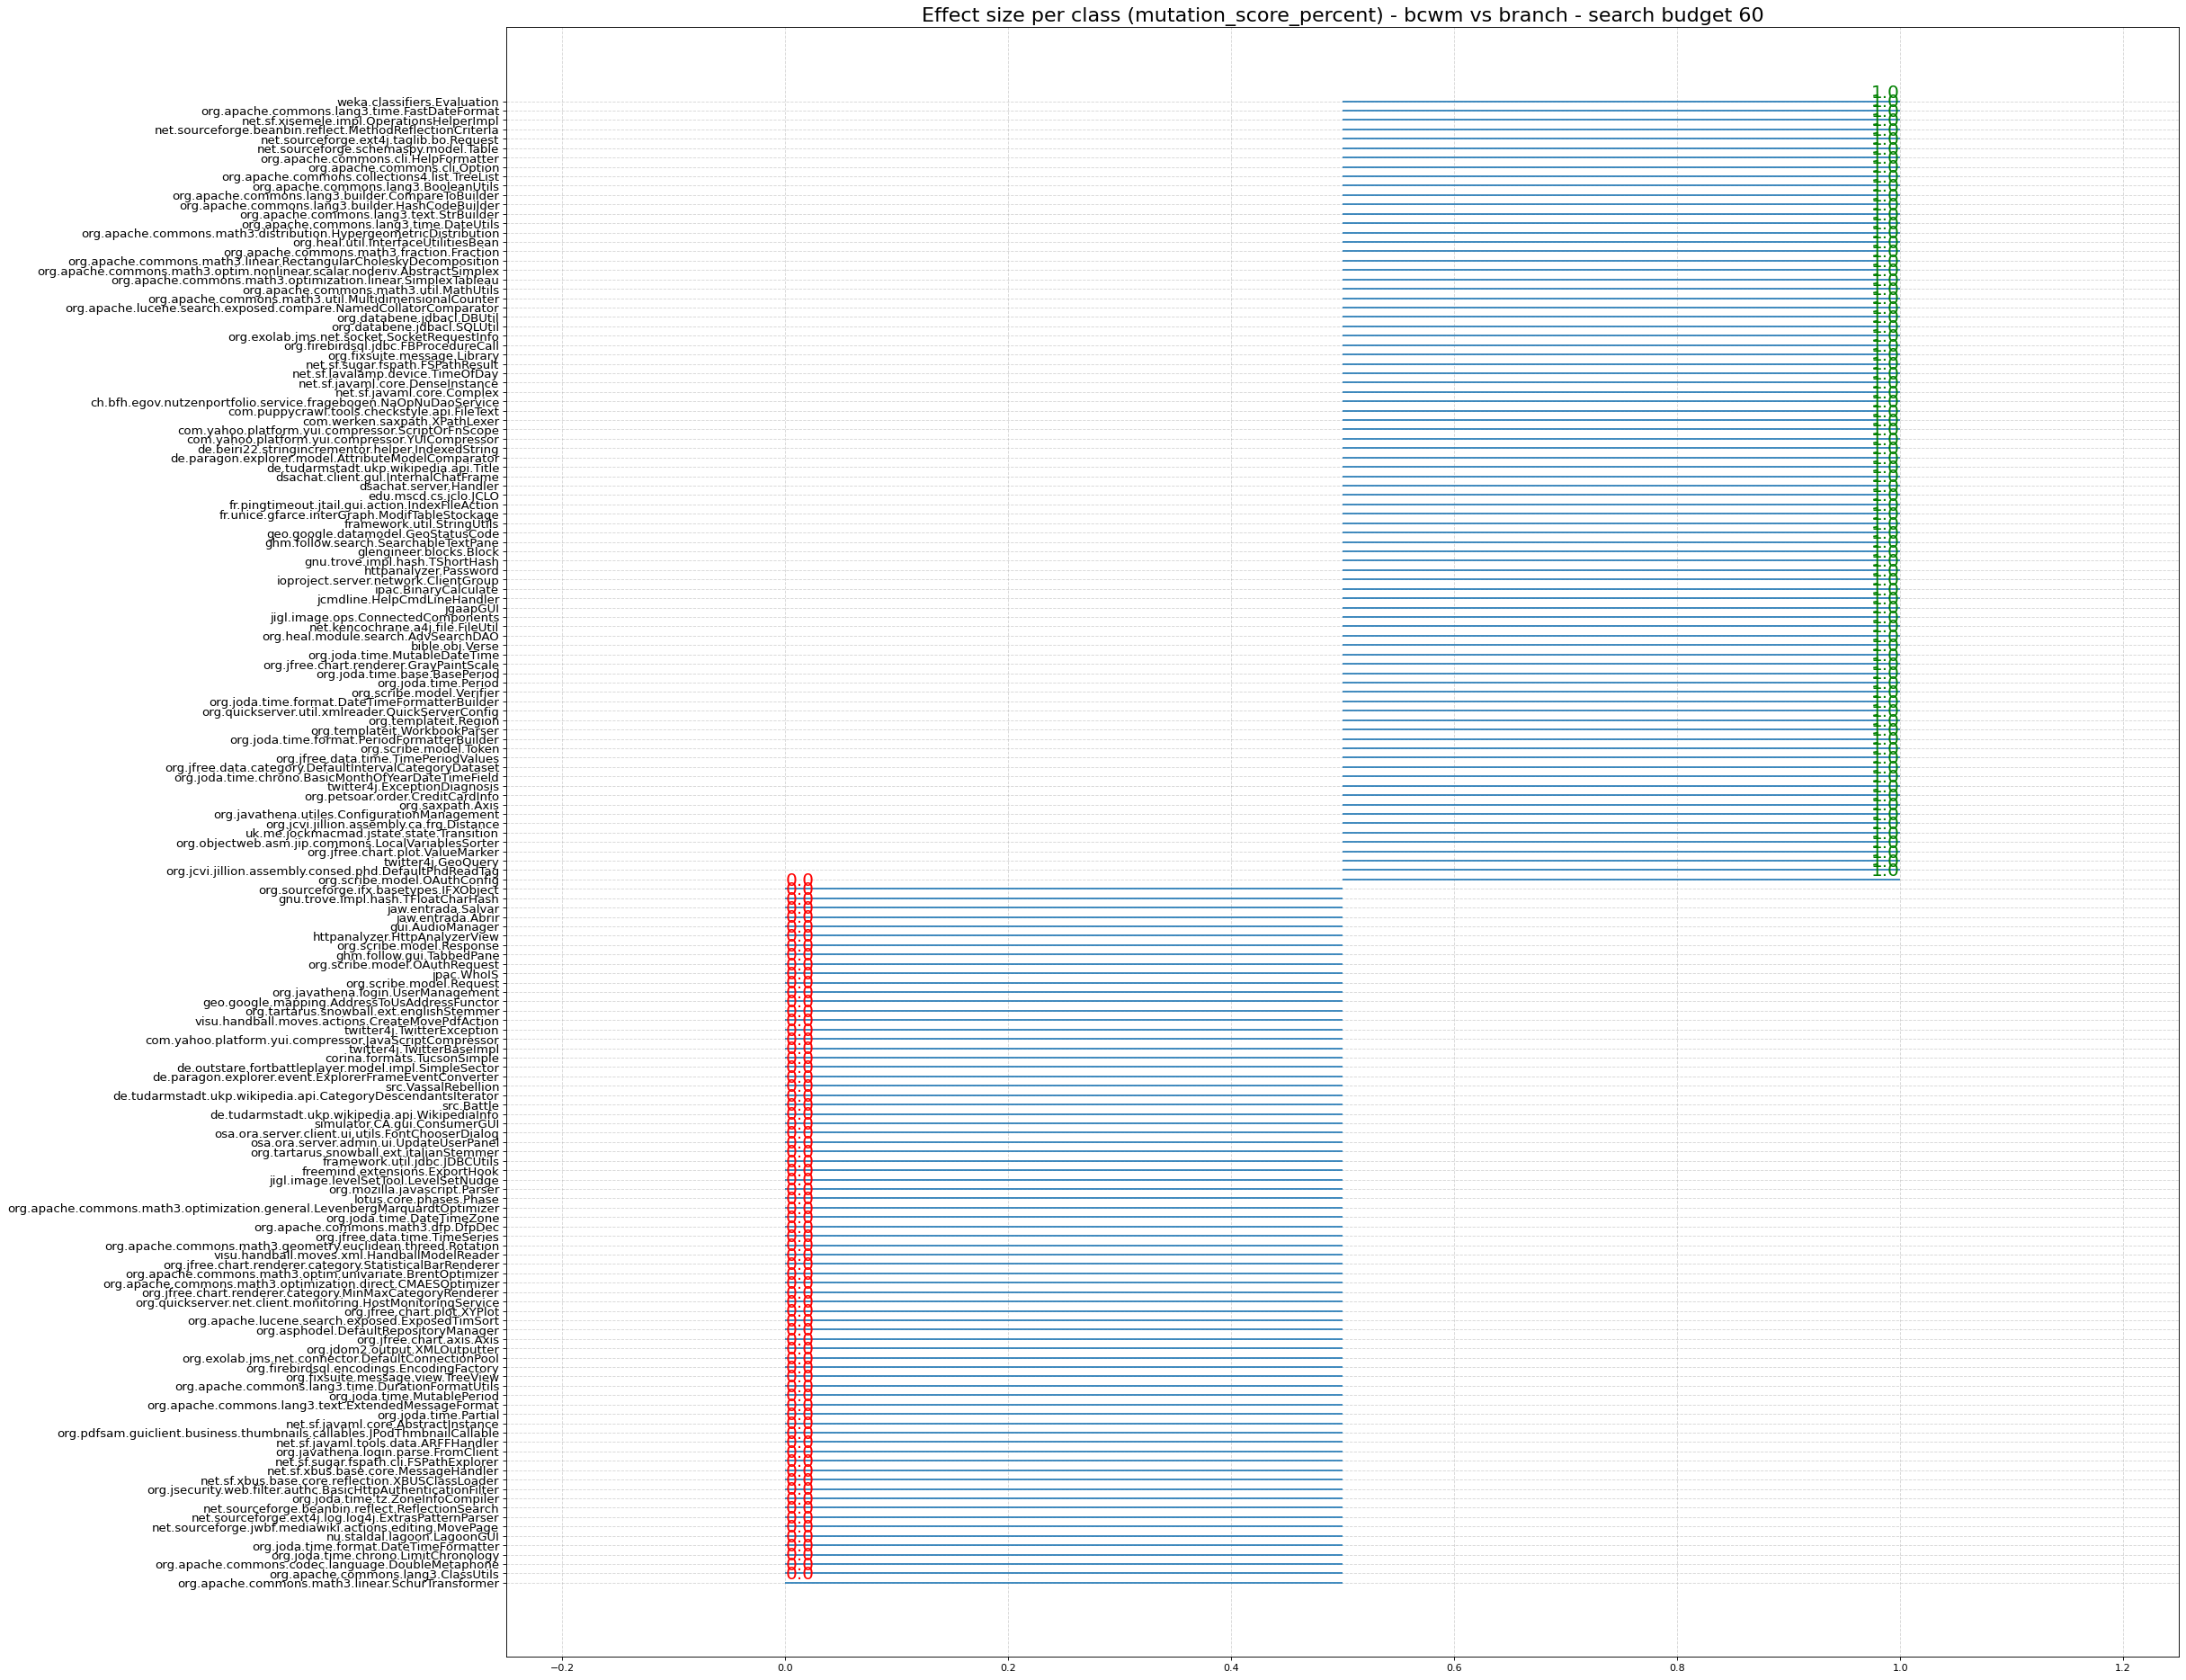

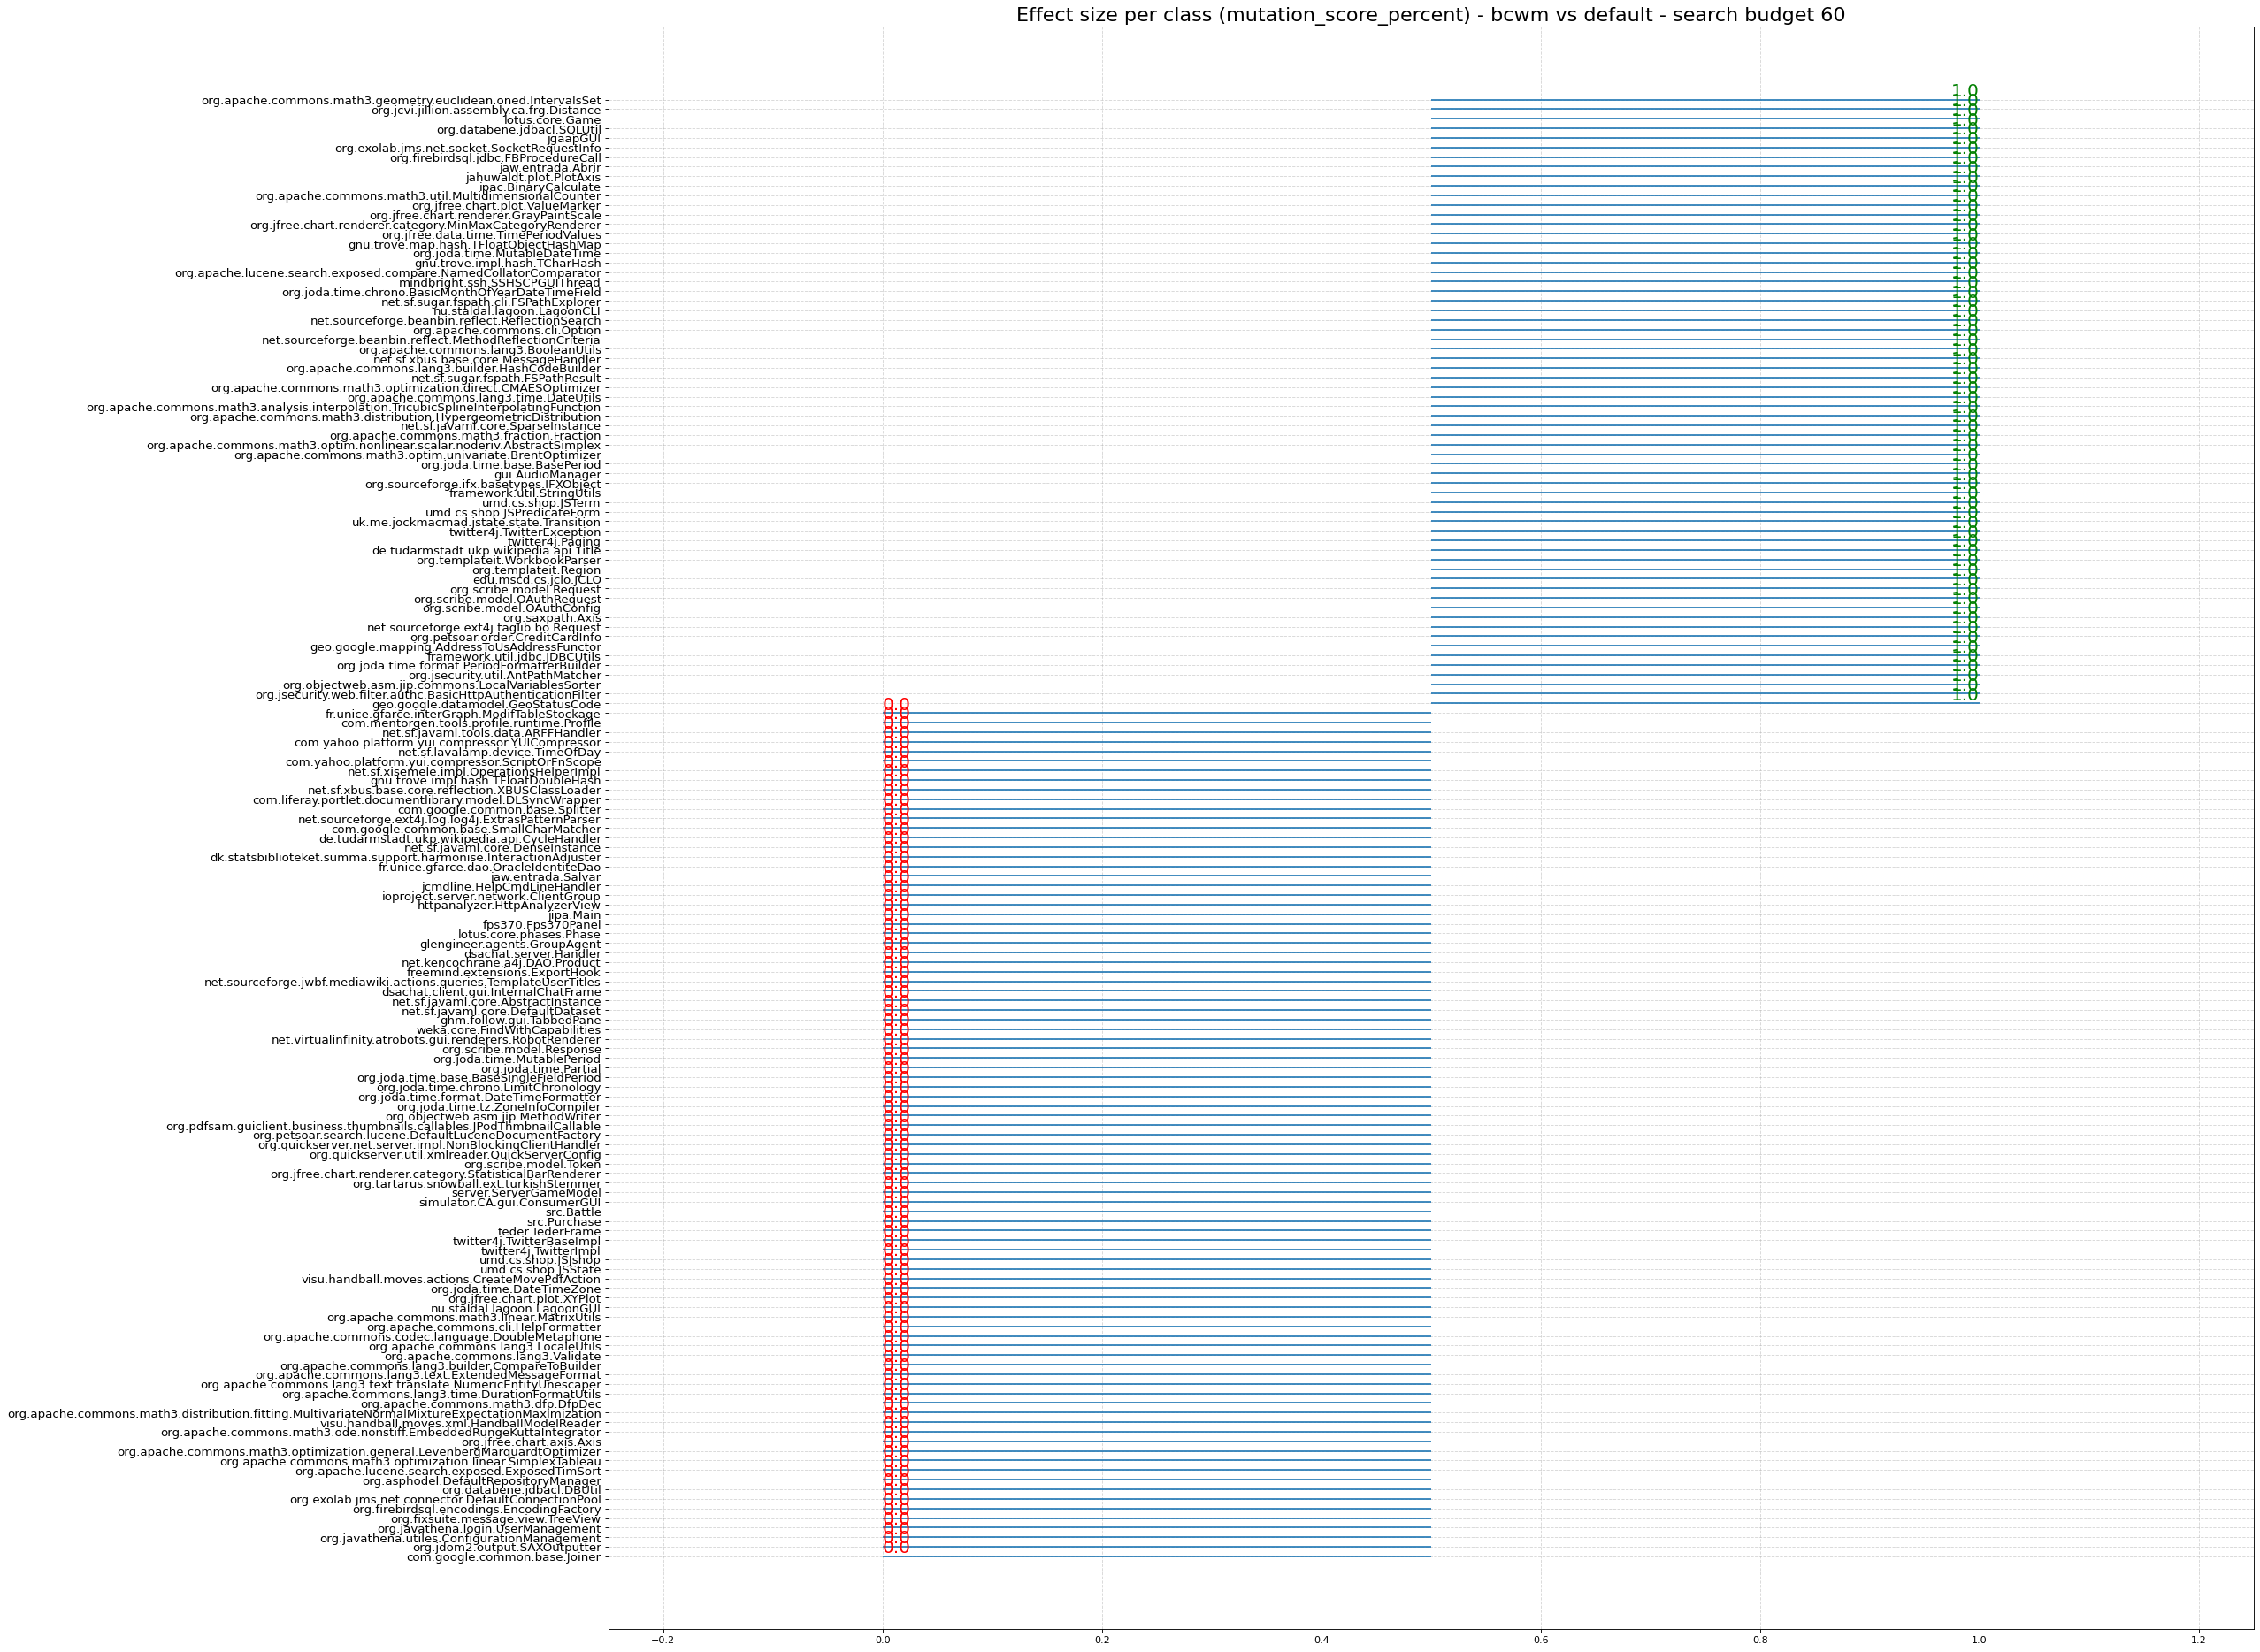

In [5]:
def plot_for_budgets(search_budgets, score_metric_filename, columns_to_group, score_metric, sample_range=None):
    
    significant_classes_stats = {}
    for search_budget in search_budgets:
        key_budget = 'stats' + str(search_budget)

        # Contains the coverage results per class from EvoSuite (e.g. score_metric_filename = "res_data/results-60.csv")
        if ('mutation' not in score_metric_filename):
            score_metric_filename = 'res_data/results-' + str(search_budget) + '.csv'
        
        # significant_classes_stats['stats60_fitness'][0][class][0] -> Wilcoxon results (tuple) for significant classes
        # significant_classes_stats['stats60_fitness'][0][class][1] -> Vargha-Delaney results (tuple) for significant classes
        # Use ['stats60_fitness'][1] for all classes stats and not only the significant ones
        
        # Contains statistically significant classes at [0] and all classes at [1]
        # res_dict['stats60_branch'][0].items() contains pairs of type (class_name, p-value)
        significant_classes_stats[str(key_budget + '_branch')] = get_significant_classes_stats(
            score_metric_filename,
            search_budget,
            'branch',
            columns_to_group,
            score_metric)

        significant_classes_stats[str(key_budget + '_default')] = get_significant_classes_stats(
            score_metric_filename,
            search_budget,
            'default',
            columns_to_group,
            score_metric)


        plot_diverging_text(search_budget, 'branch', significant_classes_stats[str(key_budget + '_branch')][0], score_metric, sample_range)
        plot_diverging_text(search_budget, 'default', significant_classes_stats[str(key_budget + '_default')][0], score_metric, sample_range)

    return significant_classes_stats

# BRANCH COVERAGE
search_budgets=[60, 180, 300]
sample_range=None
columns_to_group=['TARGET_CLASS', 'configuration_id', 'project.id']
score_metric='BranchCoverage'
score_metric_filename='res_data/results-'

significant_classes_stats_coverage = plot_for_budgets(search_budgets, score_metric_filename, columns_to_group, score_metric, sample_range)

# MUTATION SCORE
search_budgets=[60]
sample_range=None
columns_to_group=['class', 'configuration', 'project']
score_metric='mutation_score_percent'
score_metric_filename='res_data/mutation_scores.csv'

significant_classes_stats_mutation = plot_for_budgets(search_budgets, score_metric_filename, columns_to_group, score_metric, sample_range)    

In [14]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

classes_to_analyse_coverage_branch = []

classes_to_analyse_coverage_branch60 = (list(significant_classes_stats_coverage['stats60_branch'][0].keys()))
classes_to_analyse_coverage_branch180 = (list(significant_classes_stats_coverage['stats180_branch'][0].keys()))
classes_to_analyse_coverage_branch300 = (list(significant_classes_stats_coverage['stats300_branch'][0].keys()))
classes_to_analyse_coverage_branch = list(set(classes_to_analyse_coverage_branch60 + classes_to_analyse_coverage_branch180 + classes_to_analyse_coverage_branch300))
# print(len(classes_to_analyse_coverage_branch))

classes_to_analyse_coverage_default = []

classes_to_analyse_coverage_default60 = (list(significant_classes_stats_coverage['stats60_default'][0].keys()))
classes_to_analyse_coverage_default180 = (list(significant_classes_stats_coverage['stats180_default'][0].keys()))
classes_to_analyse_coverage_default300 = (list(significant_classes_stats_coverage['stats300_default'][0].keys()))
classes_to_analyse_coverage_default = list(set(classes_to_analyse_coverage_default60 + classes_to_analyse_coverage_default180 + classes_to_analyse_coverage_default300))
# print(len(classes_to_analyse_coverage_default))

classes_to_analyse_coverage = list(set(classes_to_analyse_coverage_branch + classes_to_analyse_coverage_default))

print('---- budget 60: ')
print('branch: ' + str(len(classes_to_analyse_coverage_branch60)))
print('default: ' + str(len(classes_to_analyse_coverage_default60)))
print('intersection: ' + str(len(intersection(classes_to_analyse_coverage_branch60, classes_to_analyse_coverage_default60))))
print(len(significant_classes_stats_coverage['stats60_branch'][1]))

print('---- budget 180: ')
print('branch: ' + str(len(classes_to_analyse_coverage_branch180)))
print('default: ' + str(len(classes_to_analyse_coverage_default180)))
print('intersection: ' + str(len(intersection(classes_to_analyse_coverage_branch180, classes_to_analyse_coverage_default180))))
print(len(significant_classes_stats_coverage['stats180_branch'][1]))

print('---- budget 300: ')
print('branch: ' + str(len(classes_to_analyse_coverage_branch300)))
print('default: ' + str(len(classes_to_analyse_coverage_default300)))
print('intersection: ' + str(len(intersection(classes_to_analyse_coverage_branch300, classes_to_analyse_coverage_default300))))
print(len(significant_classes_stats_coverage['stats300_branch'][1]))

# classes_to_analyse_coverage = dict()
# classes_to_analyse_coverage['default60'] = significant_classes_stats_coverage['stats60_default'][0].keys()
# classes_to_analyse_coverage['default180'] = significant_classes_stats_coverage['stats180_default'][0].keys()
# classes_to_analyse_coverage['default300'] = significant_classes_stats_coverage['stats300_default'][0].keys()
# classes_to_analyse_coverage = np.array(list(classes_to_analyse_coverage))

---- budget 60: 
branch: 189
default: 174
intersection: 139
336
---- budget 180: 
branch: 189
default: 186
intersection: 144
336
---- budget 300: 
branch: 238
default: 176
intersection: 137
334


In [15]:
classes_to_analyse_mutation_branch60 = list(significant_classes_stats_mutation['stats60_branch'][0].keys())
classes_to_analyse_mutation_default60 = list(significant_classes_stats_mutation['stats60_default'][0].keys())
classes_to_analyse_mutation = list(set(classes_to_analyse_mutation_branch60 + classes_to_analyse_mutation_default60))

print('---- budget 60: ')
print('branch: ' + str(len(classes_to_analyse_mutation_branch60)))
print('default: ' + str(len(classes_to_analyse_mutation_default60)))
print('intersection: ' + str(len(intersection(classes_to_analyse_mutation_branch60, classes_to_analyse_mutation_default60))))
print(len(classes_to_analyse_mutation))

---- budget 60: 
branch: 159
default: 153
intersection: 135
207
